In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Arial'] #set font type
from IPython.display import Image
from compute_interception import daily_interception_threshold
from compute_ET import *
import parameters
from parameters import *
import initialize_parameter_arrays
from data_processing import *
import importlib
import os
from infiltration_models import *

### Read input data

In [6]:
#source directory
src=r"W:\VUB\_main_research\scripts\wetland_model\conceptual_model\data"

pET_k = 0.408 * (delta/(delta + gamma)) * net_radiation
precip=pd.read_csv(os.path.join(src,"Boechout_precip_ETo.csv"), index_col=0)
precip.index=pd.to_datetime(precip.index, format='%d/%m/%Y')

#precipitation and ET data
p_ETo=pd.read_csv(os.path.join(src,"Boechout_precip_ETo.csv"), index_col=0)
p_ETo.index=pd.to_datetime(p_ETo.index, format='%d/%m/%Y')
relative_humidity=(pd.read_csv(os.path.join(src,"Boechout_mswx_relative_humidity.csv"), index_col=0))/100
relative_humidity.index=pd.to_datetime(relative_humidity.index, format='%d/%m/%Y')
                            
#observed water table depth data
obs_water_table=pd.read_csv(src+"/monthly_groundwater_depth.csv", index_col=0)
obs_water_table.index=pd.to_datetime(obs_water_table.index)

#surface soil moisture data extracted from SMAP
smap_ssm=pd.read_excel(src+"/smap_surface_sm_boechout_9km.xlsx", index_col=0)
smap_ssm.index=pd.to_datetime(smap_ssm.index)            

#compute components of ET equation

### Initialize arrays based on length of input data

In [7]:
# Reload the module after making changes (if needed)
importlib.reload(parameters)
importlib.reload(initialize_parameter_arrays)

# Initialize arrays based on input data length
init_params=initialize_parameter_arrays.initialized_arrays(p_ETo)

# Update the global namespace with the initialized arrays
globals().update(init_params)

### Set initial values of processes

In [8]:
interception[0]=0.05*LAI

net_precipitation[0]=p_ETo['precipitation'].iloc[0]-interception[0]

s[0]=sfc*0.5 #initial soil moisture content

y[0]=obs_water_table['A3'].iloc[0] #initial water table depth (thickness of unsaturated zone) (cm)

AWC[0]=n*y[0]*(sfc-s[0]) #initial water storage in the soil

water_table_elevation[0]=ref_elev-y[0] #initial groundwater elevation

y_WL[0]=10900 #initial water level in wetland

wetland_wl_elev[0]=y_WL[0]+ref_elev_WL #water level in wetland in reference to a datum

A2[0]=(9555.95988+8644.93182)/2
y_rech[0]=0

moisture_dep_factor[0]=0.05

A_ratio[0]=A1/A2[0]

gradient_local[0]=(water_table_elevation[0]-wetland_wl_elev[0])/L_GWlocal #gradient between local gw and wetland

tR_local[0]=L_GWlocal*phi_GWlocal/(Kh_GWlocal*gradient_local[0]) #local response time

qLOCAL_GW[0]=(water_table_elevation[0]-wetland_wl_elev[0])/tR_local[0] #local subsurface flow component

Q_GWreg[0]=Kh_GWreg*((water_table_elevation[0]-wetland_wl_elev[0])/(phi_GW*L_GWreg))

gradient_outflow[0]=(water_table_elevation[0]-wetland_wl_elev[0])/L_GWout # 

tR_out[0]=L_GWout*n/(Kh_GWout*gradient_outflow[0])

qGW_out[0]=(water_table_elevation[0]-wetland_wl_elev[0])/tR_out[0]
run_off[0]=0

# Initial conditions
sm[0] = s_fc  # Initial soil moisture is at field capacity
E_stress_tc[0] = 1  # Initial evaporation stress is 1
E_stress_sc[0] = 1  
E_stress_bs[0] = 1  
infil[0] = 0.5 * s_fc  # max infiltration at the start
perco[0] = 0  # No percolation at the start
total_evap[0] = 0
evap_actual_tc[0] =  0.5 #initial evaporation
evap_actual_sc[0] =  0.5
evap_actual_bs[0] =  0.5
interception[0] = 0.1  #
AWC[0] = 0.5
soil_depth = 300  # mm

### Downstream boundary


In [4]:
well_ref_elev = 100  # Reference elevation of the well (m)

# Initialize arrays for well variables
y_well = np.zeros(len(p_ETo))  # Water table depth at the well
elevation_well = np.zeros(len(p_ETo))  # Groundwater elevation at the well
Q_well = np.zeros(len(p_ETo))  # Net groundwater flux at the well

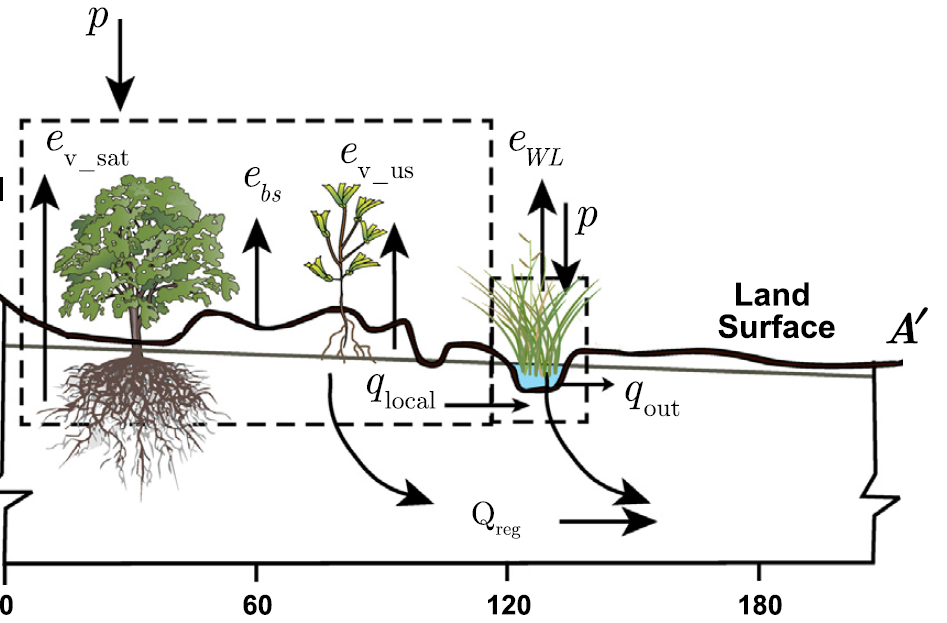

In [370]:
# Displaying the image
img_path = "schematic_representation.png"  # Ensure this file exists in the same directory
Image(filename=img_path, width=400, height=400)

#### Model implementation

In [ ]:
s_sce = 0.20
s_molecular_suction = 0.20
sfc = 0.50
dt=1
for time in range(1,len(p_ETo)-1):
    # Step 1: Calculate interception
    interception[time] = min(precip['precipitation'].iloc[time], 0.05 * LAI)

    # Step 2: Evaporate interception first
    if interception[time] >= pET_k.iloc[time]:
        # If interception alone satisfies PET, total ET is limited to PET
        total_evap[time] = pET_k.iloc[time]
        evap_actual_tc[time] = 0  # No evaporation from tall canopy
        evap_actual_sc[time] = 0  # No evaporation from short canopy
        evap_actual_bs[time] = 0  # No evaporation from bare soil
    else:
        # Subtract interception from PET to calculate remaining PET
        remaining_PET = pET_k.iloc[time] - interception[time]

        # Step 3: Calculate evaporation stress for different components
        E_stress_tc[time] = max(0,1 - ((s_fc - sm[time - 1]) / (s_fc - s_wp))**2)
        E_stress_sc[time] = max(0,0.5 * (1 - np.sqrt((s_fc - sm[time-1]) / (s_fc - s_wp)) + tau / 0.8))
        E_stress_bs[time] = max(0,1 - np.sqrt((s_fc - sm[time-1]) / (s_fc - s_wp)))

        # Calculate potential evaporation for each component
        pot_evap_tc = remaining_PET * frac_tall_canopy * alpha_tall_canopy
        pot_evap_sc = remaining_PET * frac_short_canopy * alpha_short_canopy
        pot_evap_bs = remaining_PET * frac_bare_soil * alpha_short_canopy

        # Calculate actual evaporation for each component
        evap_actual_tc[time] = pot_evap_tc * E_stress_tc[time]
        evap_actual_sc[time] = pot_evap_sc * E_stress_sc[time]
        evap_actual_bs[time] = pot_evap_bs * E_stress_bs[time]

        # Step 4: Calculate total ET
        total_evap[time] = (
            interception[time] + evap_actual_tc[time] + evap_actual_sc[time] + evap_actual_bs[time]
        )

    # Step 5: Calculate infiltration
    #caculate available water capacity
    AWC[time] = max(0, (s_fc - sm[time-1]) * soil_depth)

    #Calculate cumulative infiltration using the explicit infiltration models for sandy loam soil: 
    # Create an instance of the model
    infiltration_model = InfiltrationModel(Ks, S)

    # Calculate cumulative daily infiltration in mm
    daily_infiltration = infiltration_model.valiantzas_model(dt) * 24  # converting hourly to daily
    infil[time] = min(daily_infiltration, precip['precipitation'].iloc[time] - interception[time])
    
    # Step 6: Update soil moisture (before percolation)
    sm[time] = sm[time - 1] + (infil[time] - total_evap[time]) / soil_depth

    # Step 7: Calculate percolation if soil moisture exceeds field capacity
    if sm[time] >= s_fc:
        perco[time] = (sm[time] - s_fc) * soil_depth  # Excess water becomes percolation
        sm[time] = s_fc  # Soil moisture is capped at field capacity
    else:
        perco[time] = 0  # No percolation if below field capacity

    # Step 8: Enforce lower boundary for soil moisture
    sm[time] = max(s_wp, sm[time])  # Prevent negative soil moisture
 
 #Update soil moisture content due to vegetation evaporation
    if y[time] > 0:  # Check if water table is below the surface
        # Calculate the change in soil moisture
        s[time] =s[time]- (eveg_us[time] / (n * y[time])) * dt
        # Update soil moisture using max() to ensure it remains non-negative
        s[time] = max(s_sce, s[time])

    y[time] = y[time - 1] - (perco[time] / (n * (1 - sfc))) 


    """//////////Groundwater flow///////////"""
    # calculate saturated zone evaportanspiration from vegetation
    eveg_sat[time] = 0.6 * evap_actual_tc[time]

    
    #local subsurface groundwater flow component
    qLOCAL_GW[time]=(qGW_Local[time]/(n*(1-sfc)))*dt

    #steady state regional groundwater flow
    Qss_GW[time]=(Q_GWreg[time]/(n*(1-sfc)))*dt

     # Update water table depth due to saturated zone evaporation by vegetation
    y[time] += (eveg_sat[time - 1] / (n * (1 - sfc))) * dt

    y[time] += Qss_GW[time - 1] * dt

    y[time] +=  qLOCAL_GW[time-1] * dt

    # # Ensure the water table does not exceed the surface level
    y[time] = max(y[time], 0)


    # Calculate groundwater elevation
    water_table_elevation[time] = ref_elev - y[time]

    """+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++"""
    
    """//////////Downstream Well Water Balance///////////"""
    # Step 1: Recharge to the aquifer
    
    recharge[time] = min(infil[time], (sfc - sm[time - 1]) * soil_depth)  # Recharge to the aquifer

    # Step 2: Evapotranspiration from the saturated zone near the well
    if y_well[time - 1] > 0:  # Water table below the surface
        eveg_sat[time] = 0.6 * evap_actual_tc[time]  # Adjust ET from saturated zone
    else:
        eveg_sat[time] = 0

    # Step 3: Local groundwater flow to/from the well
    gradient_local_well = (water_table_elevation[time - 1] - elevation_well[time - 1]) / L_GWlocal
    q_local_well = Kh_GWlocal * gradient_local_well  # Darcy's Law for local groundwater flow

    # Step 4: Regional groundwater flow to/from the well
    gradient_reg_well = (regional_head[time - 1] - elevation_well[time - 1]) / L_GWreg
    q_reg_well = Kh_GWreg * gradient_reg_well  # Regional groundwater flow (Darcy's Law)

    # Step 5: Update water table depth at the well
    # Subtract evapotranspiration and add inflows (recharge + local flow + regional flow)
    y_well[time] = y_well[time - 1] + (
        (recharge[time] - eveg_sat[time] + q_local_well + q_reg_well) / (n * (1 - sfc))
    ) * dt

    # Step 6: Enforce boundary conditions for the well water level
    y_well[time] = max(y_well[time], 0)  # Ensure the water table does not exceed the surface
    y_well[time] = min(y_well[time], aquifer_depth)  # Prevent falling below aquifer base

    # Step 7: Calculate groundwater elevation at the well
    elevation_well[time] = well_ref_elev - y_well[time]

    """//////////REGIONAL AND LOCAL GROUNDWATER FLUX///////////"""
    # Regional groundwater flow
    Qss_GW[time] = q_reg_well * dt

    # Local groundwater flow
    qLOCAL_GW[time] = q_local_well * dt

    # Net groundwater flux at the well
    Q_well[time] = recharge[time] - eveg_sat[time] + q_local_well + q_reg_well

    # Track changes in groundwater elevation
    deltaH_groundwater[time] = elevation_well[time] - elevation_well[time - 1]

    """//////////SOIL MOISTURE BALANCE///////////"""
    # Update soil moisture content in the vadose zone
    sm[time] = sm[time - 1] + (infil[time] - total_evap[time]) / soil_depth

    # Enforce field capacity and wilting point limits
    if sm[time] > sfc:
        perco[time] = (sm[time] - sfc) * soil_depth  # Excess water becomes percolation
        sm[time] = sfc
    else:
        perco[time] = 0

    sm[time] = max(s_wp, sm[time])  # Prevent negative soil moisture

    # Update water table due to percolation
    y_well[time] -= (perco[time] / (n * (1 - sfc)))

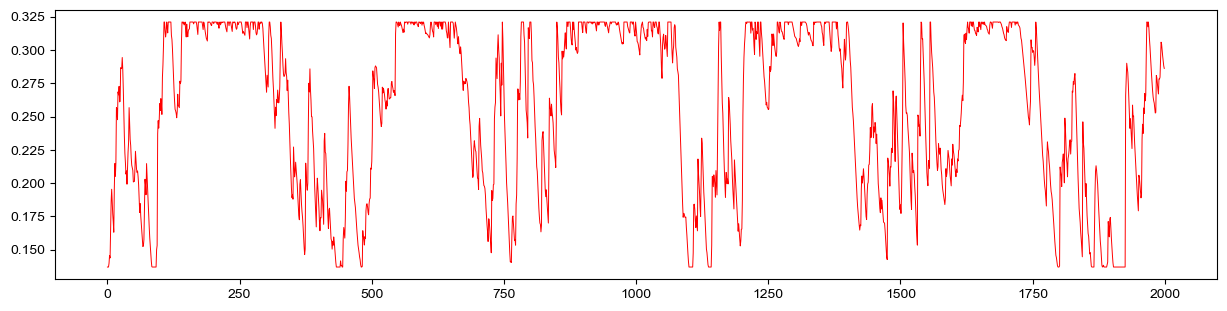

In [372]:
fig, ax = plt.subplots(figsize=(15, 3.5))
#plt.plot(net_precipitation[1600:], c='b')
plt.plot(sm[1600:3600], c='r',ls='-', lw = 0.7)
#plt.plot(run_off[1600:], c='g')

### Plots

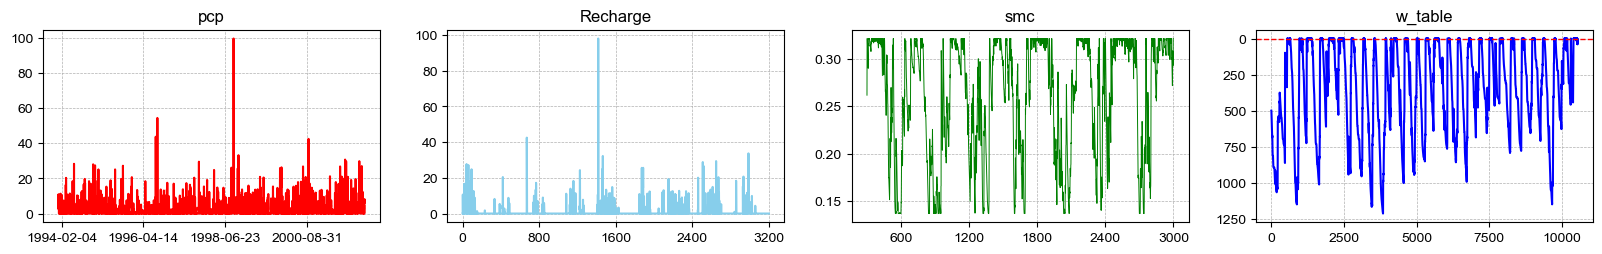

In [373]:
s_df=pd.DataFrame(sm)

fig,[ax1,ax2,ax3,ax4]=plt.subplots(1,4,figsize=(20, 2.5))

#set spacing between subplots
plt.subplots_adjust(wspace=0.2)

ax1.plot(p_ETo['precipitation'][0:3000], c='r')
ax2.plot(perco[300:3500], c='skyblue')
ax3.plot(s_df[300:3000],c='g', linewidth=0.7)
#ax3.set_ylim(0.1, 0.65)
ax4.plot(y[500:-1], c='b')
ax4.axhline(y=0, color='r', linestyle='--', linewidth=1.0)
#ax3.set_ylim(100, 250)
#invert y axis
ax4.invert_yaxis()
for ax in [ax1, ax2, ax3, ax4]:
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    #set grid spacing
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))
    ax.set_title(['pcp','Recharge','smc','w_table'][[ax1,ax2,ax3,ax4].index(ax)])

In [374]:
perco.mean()*365, total_evap.mean()*365, ep_WL.mean()*365

(306.54031518841225, 524.6454038089505, 0.0)

#### Compare simulated soil moisture and water table depth with reference data

> Convert model outputs to arrays and aggregate selected variables to monthly intervals

In [375]:
#convert output arrays to dataframes for convenient plotting
output_arrays=[interception,y,perco,sm,run_off, qGW_Local, qGW_out, Q_GWreg, total_evap, ep_WL]

output_df=[pd.DataFrame(arr) for arr in output_arrays]
sim_df=pd.concat(output_df, axis=1)

sim_df.columns=['interception','water_table_depth','recharge','soil_moisture','run_off','qGW_Local','qGW_out','Q_GWreg','total_evap','ep_WL']
sim_df.index=p_ETo.index

#Monthly values
s_df_monthly=sim_df['soil_moisture'].resample('ME').mean()
smap_ssm_monthly=smap_ssm.resample('ME').mean()
y_df_monthly=sim_df['water_table_depth'].resample('ME').mean()
obs_water_table_monthly=obs_water_table.resample('ME').mean()

Text(0, 0.5, 'Water table depth (m)')

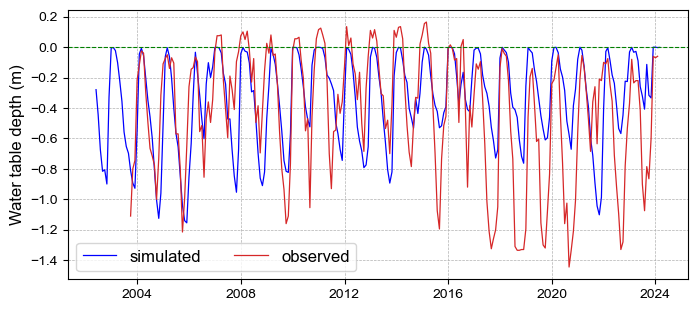

In [376]:
plt.figure(figsize=(8, 3.5))
plt.plot((-1*y_df_monthly[100:-1])/1000, c='b', label='simulated', linewidth=0.9)
plt.plot((-1*obs_water_table['A3']), 'C13', label='observed', linewidth=0.9)
plt.axhline(y=0, color='g', linestyle='--', linewidth=.8)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='best', fontsize=12, ncol=2)
plt.ylabel('Water table depth (m)', fontsize=12)

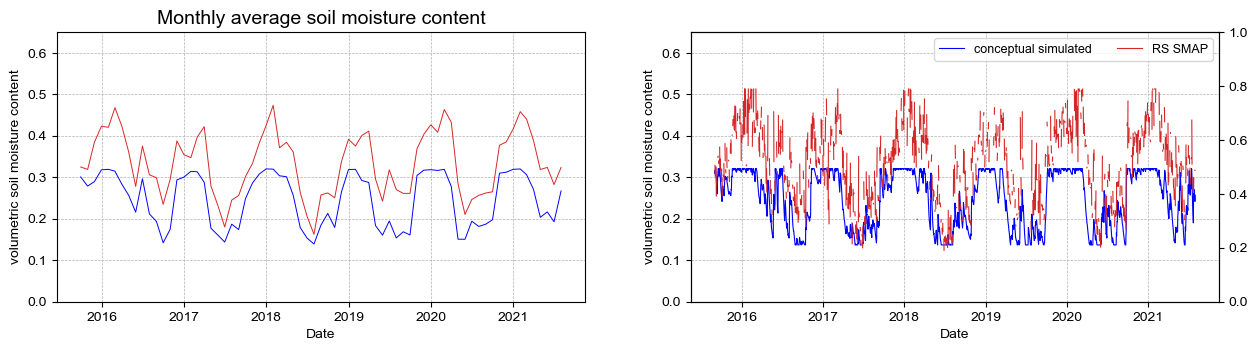

In [377]:
start_date='2015-09-01'
end_date='2021-07-31'


fig,axis=plt.subplots(1,2,figsize=(15, 3.5))
for ax in axis:
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    #ax.xaxis.set_major_locator(plt.MaxNLocator(6))
    ax.set_xlabel('Date')
    ax.set_ylabel('volumetric soil moisture content')
    ax.set_ylim(0., 0.65)
    
axis[0].plot((s_df_monthly[start_date:end_date]), c='b', label='conceptual simulated', linewidth=0.7)
axis[0].plot(smap_ssm_monthly[start_date:end_date], 'C13', label='RS SMAP', linewidth=0.7)

axis[1].plot((sim_df['soil_moisture'][start_date:end_date]), c='b', label='conceptual simulated', linewidth=0.8)
axis[1].plot(smap_ssm[start_date:end_date], 'C13', label='RS SMAP', linewidth=0.8)
axis[0].set_title('Monthly average soil moisture content', fontsize=14)
ax.legend(loc='best', fontsize=9, ncols=2)
#plot water table depth on secondary y-axis
ax2=axis[1].twinx()
# ax2.plot((obs_water_table_monthly['A3'][start_date:end_date]), c='c', label='water table depth', linewidth=0.7);
# ax2.plot((y_df_monthly[start_date:end_date])/1000, c='r', label='water table depth', linewidth=0.7);

(0.0, 0.55)

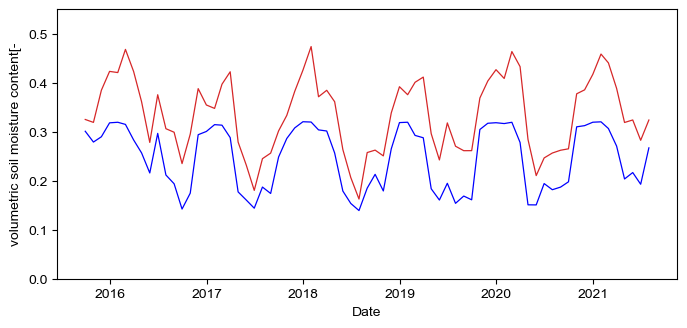

In [378]:
fig,axis=plt.subplots(figsize=(8.0, 3.5))

#ax.xaxis.set_major_locator(plt.MaxNLocator(6))
plt.plot((s_df_monthly[start_date:end_date]), c='b', label='conceptual simulated', linewidth=0.9)
plt.plot(smap_ssm_monthly[start_date:end_date], 'C13', label='RS SMAP', linewidth=0.9)

plt.xlabel('Date')
plt.ylabel('volumetric soil moisture content[-')
plt.ylim(0., 0.55)

Correlation coefficient: 0.554


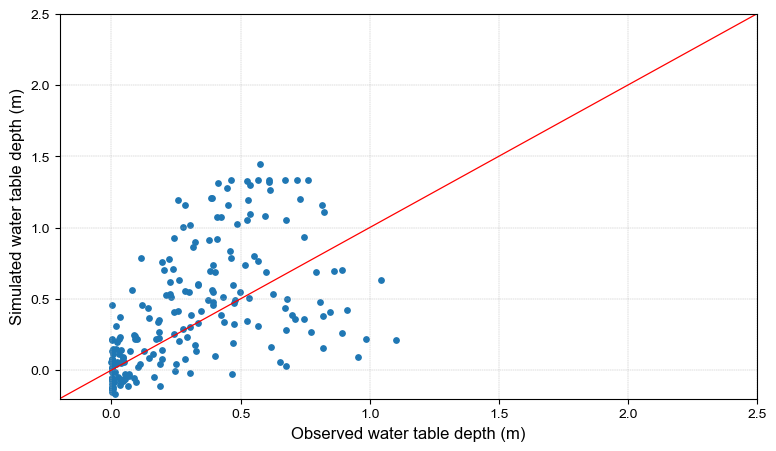

In [379]:
#scatter plot of observed and simulated water table depth
plt.figure(figsize=(9, 5))
plt.scatter(y_df_monthly['2007-01-01':'2023-12-31']/1000, obs_water_table_monthly['A3']['2007-01-01':'2023-12-31'],s=15)
plt.xlabel('Observed water table depth (m)', fontsize=12)
plt.ylabel('Simulated water table depth (m)', fontsize=12)

#calculate correlation coefficient
corr = np.corrcoef(obs_water_table_monthly['A3']['2007-01-01':'2023-12-31'],y_df_monthly['2007-01-01':'2023-12-31'])
#add 1:1 line
plt.plot([-.2, 2.5], [-0.2, 2.5], 'r', linewidth=0.9)
plt.ylim(-0.2, 2.5)
plt.xlim(-0.2, 2.5)
plt.grid(True, which='both', linestyle='--', linewidth=0.3) 
print('Correlation coefficient:', np.round(corr[0, 1],3))

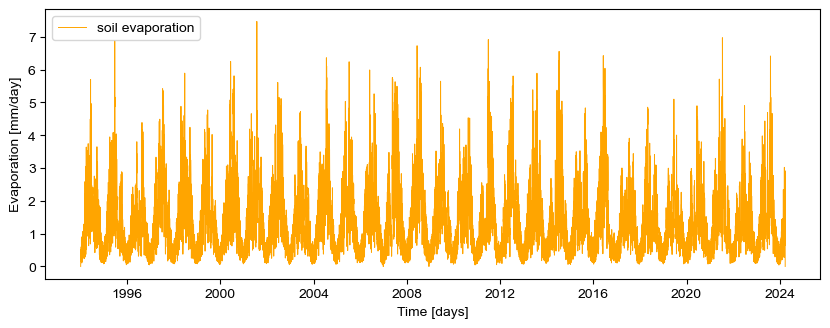

In [380]:
fig, ax = plt.subplots(figsize=(10, 3.5))
#plt.plot(np.squeeze(ep_WL), c='skyblue', linewidth=0.7, label='Wetland evaporation')
plt.plot(sim_df['total_evap'], linewidth=0.7, c='orange', label='soil evaporation')
#plt.plot(p_ETo['ETo'], c='purple', linewidth=0.7, label='potential_evapotranspiration')
plt.ylabel('Evaporation [mm/day]')
plt.xlabel('Time [days]')
plt.legend(loc='best')

Text(0.5, 0, '')

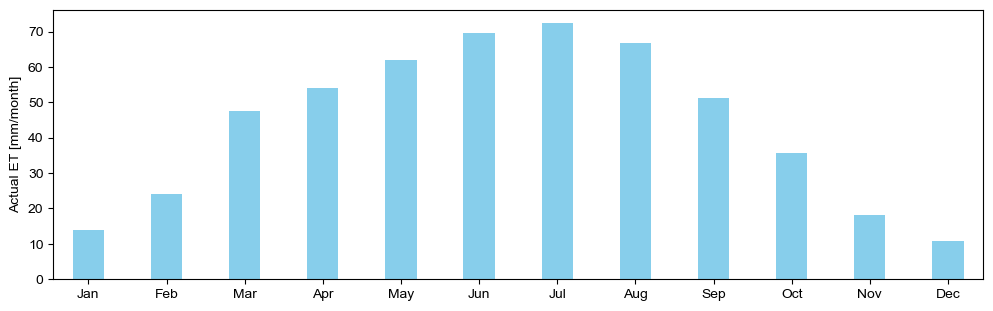

In [381]:
monthly_et = sim_df['total_evap'].resample('ME').sum()
mon_avg_et = monthly_et.groupby(monthly_et.index.month).mean()
mon_avg_et.plot(kind='bar', figsize=(12, 3.5), color='skyblue', width=0.4)
#rename x-axis ticks
plt.xticks(np.arange(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0);
plt.ylabel('Actual ET [mm/month]')
plt.xlabel('')

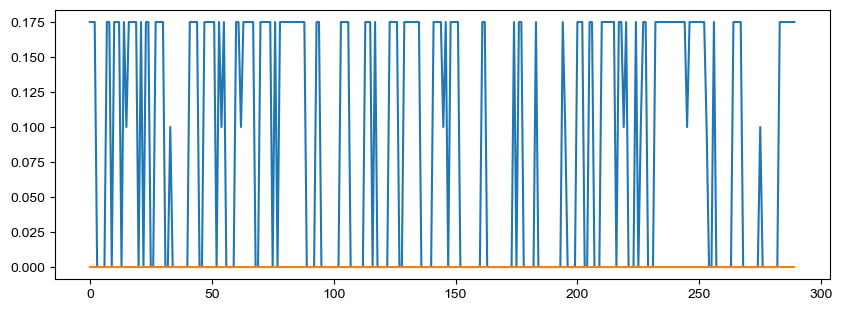

In [382]:
fig, ax = plt.subplots(figsize=(10, 3.5))
plt.plot(np.squeeze(interception[10:300]))
plt.plot(np.squeeze(interception_threshold[10:300]))

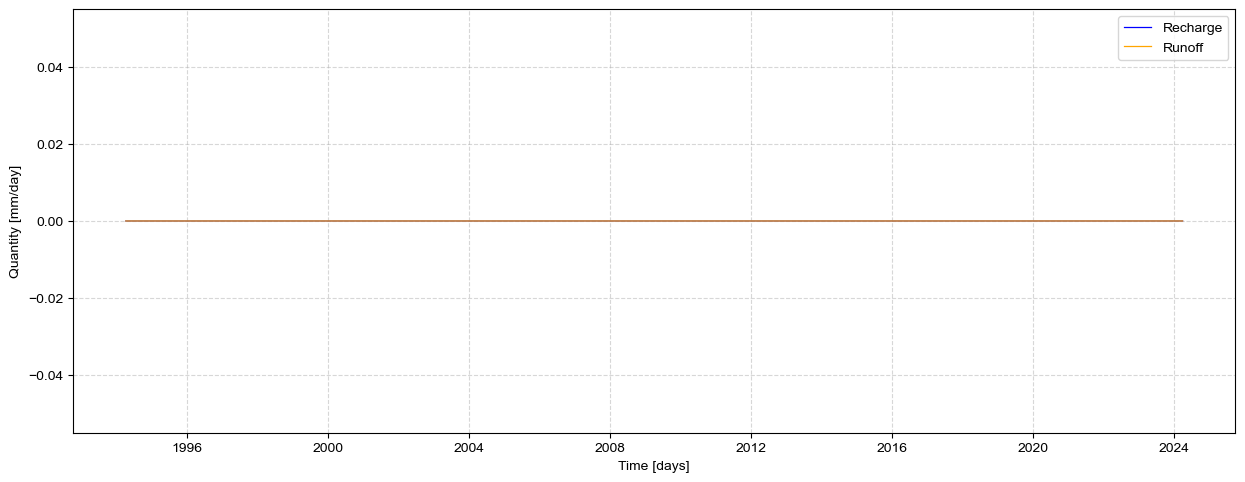

In [383]:

recharge_df=pd.DataFrame(Recharge, columns=['perco'])
run_off_df=pd.DataFrame(run_off, columns=['run_off'])
run_off_df.index=p_ETo.index

recharge_df.index=p_ETo.index


plt.figure(figsize=(15, 5.5))
#plt.plot(Recharge, c='r')
plt.plot(recharge_df[100:], c='blue', linewidth=0.9, label='Recharge')
plt.plot(run_off_df[100:], c='orange', linewidth=0.9, label='Runoff')
#plt.ylim(0.05, 0.55)
#plt.ylabel('Volumetric coil Moisture Content[-]')
plt.ylabel('Quantity [mm/day]')
plt.xlabel('Time [days]')
plt.grid(alpha=0.5, linestyle='--') 
plt.legend(loc='best')

### Groundwater Fluxes

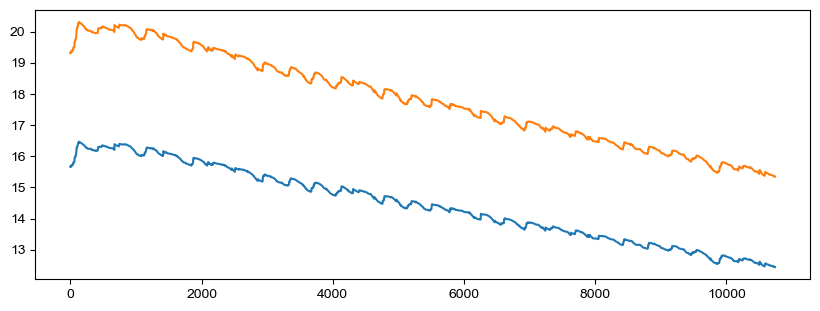

In [384]:
plt.figure(figsize=(10, 3.5))
plt.plot(np.squeeze(gradient_local[300:-1]))
plt.plot(np.squeeze(gradient_outflow[300:-1]))
# plt.plot(Q_GWreg[10:])
# plt.plot(Qss_GW[10:])

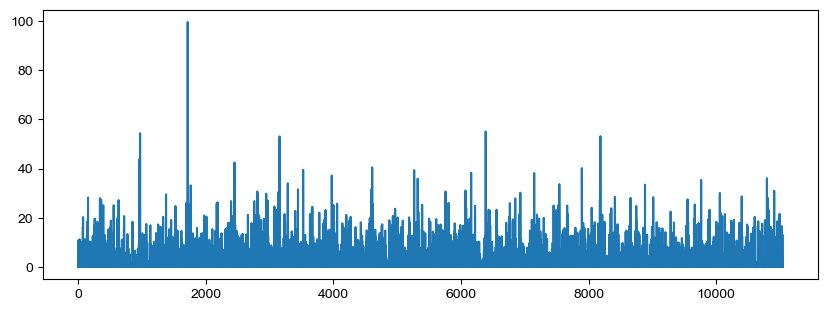

In [385]:
plt.figure(figsize=(10, 3.5))
plt.plot(np.squeeze(net_p_input[0:]))


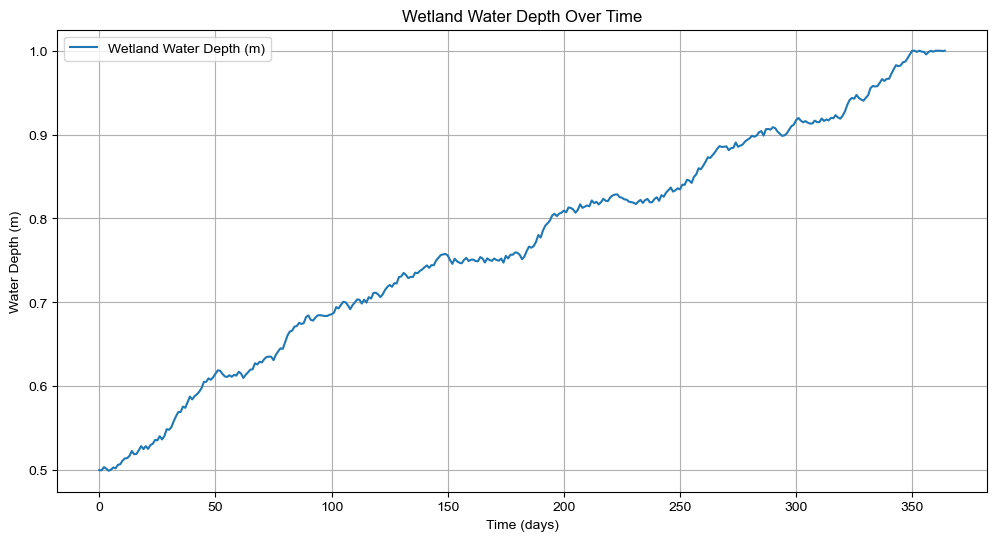

In [386]:
import numpy as np
import matplotlib.pyplot as plt

# Define constants and parameters
dt = 1  # time step in days
time_steps = 365  # simulation for one year
initial_depth = 0.5  # initial water depth in meters

# Fluxes (example values, replace with actual data)
precipitation = np.random.uniform(0, 0.01, time_steps)  # daily precipitation in meters
transpiration = np.random.uniform(0, 0.005, time_steps)  # daily transpiration in meters
outflow = np.random.uniform(0, 0.002, time_steps)  # daily outflow in meters

# Initialize arrays
depth = np.zeros(time_steps)
depth[0] = initial_depth

# Simulation loop
for t in range(1, time_steps):
    P = precipitation[t]
    T = transpiration[t]
    O = outflow[t]
    delta_h = (P - T - O) * dt
    depth[t] = depth[t-1] + delta_h

    # Ensure the depth does not exceed 1 meter
    if depth[t] > 1:
        depth[t] = 1

    # Ensure the depth does not go below 0
    if depth[t] < 0:
        depth[t] = 0

# Plotting results
plt.figure(figsize=(12, 6))
plt.plot(depth, label='Wetland Water Depth (m)')
plt.xlabel('Time (days)')
plt.ylabel('Water Depth (m)')
plt.title('Wetland Water Depth Over Time')
plt.legend()
plt.grid()
plt.show()

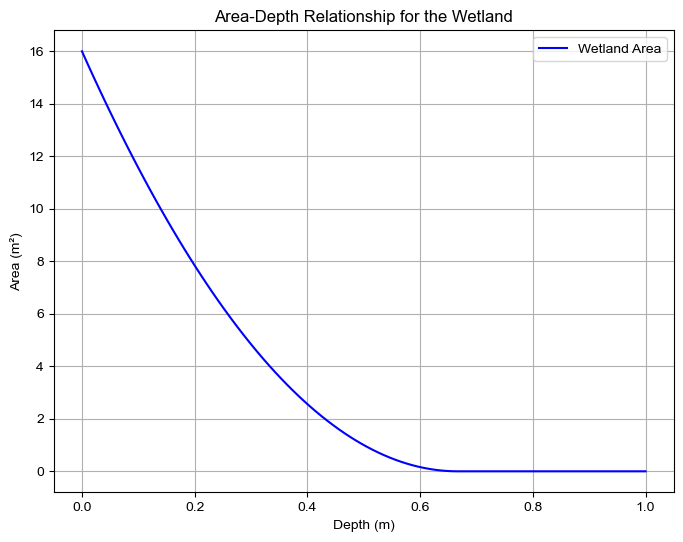

In [387]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function to calculate the area at a given depth
def calculate_area(depth, W_top, L_top, slope_ratio):
    W = W_top - 6 * depth
    L = L_top - 6 * depth
    if W <= 0 or L <= 0:
        return 0  # if dimensions go negative, area is zero (this handles edge cases)
    return W * L

# Wetland top dimensions and slope ratio
W_top = 4  # meters
L_top = 4  # meters
slope_ratio = 3  # 1:3 slope

# Generate a range of depths from 0 to 1 meter
depths = np.linspace(0, 1, 100)

# Calculate the corresponding areas
areas = [calculate_area(depth, W_top, L_top, slope_ratio) for depth in depths]

# Plot the area-depth relationship
plt.figure(figsize=(8, 6))
plt.plot(depths, areas, label='Wetland Area', color='blue')
plt.xlabel('Depth (m)')
plt.ylabel('Area (m²)')
plt.title('Area-Depth Relationship for the Wetland')
plt.legend()
plt.grid()
plt.show()


In [1]:
def simulate_soil_water_balance(
    time, sm, pET_k, precip, LAI, s_fc, s_wp, tau, soil_depth, Ks, S, dt, 
    frac_tall_canopy, frac_short_canopy, frac_bare_soil, alpha_tall_canopy, 
    alpha_short_canopy, interception, total_evap, evap_actual_tc, evap_actual_sc, 
    evap_actual_bs, AWC, infil, perco
):
    """
    Simulate the water balance for a single time step.
    """
    # Step 1: Calculate interception
    interception[time] = min(precip['precipitation'].iloc[time], 0.05 * LAI)

    # Step 2: Evaporate interception first
    if interception[time] >= pET_k.iloc[time]:
        total_evap[time] = pET_k.iloc[time] # If interception alone satisfies PET, total ET is limited to PET
        evap_actual_tc[time] = 0  # No evaporation from tall canopy
        evap_actual_sc[time] = 0  # No evaporation from short canopy
        evap_actual_bs[time] = 0  # No evaporation from bare soil
    else:
        remaining_PET = pET_k.iloc[time] - interception[time]

        # Step 3: Calculate evaporation stress for different components
        E_stress_tc = max(0, 1 - ((s_fc - sm[time - 1]) / (s_fc - s_wp))**2)
        E_stress_sc = max(0, 0.5 * (1 - np.sqrt((s_fc - sm[time - 1]) / (s_fc - s_wp)) + tau / 0.8))
        E_stress_bs = max(0, 1 - np.sqrt((s_fc - sm[time - 1]) / (s_fc - s_wp)))

        # Calculate potential evaporation for each component
        pot_evap_tc = remaining_PET * frac_tall_canopy * alpha_tall_canopy
        pot_evap_sc = remaining_PET * frac_short_canopy * alpha_short_canopy
        pot_evap_bs = remaining_PET * frac_bare_soil * alpha_short_canopy

        # Calculate actual evaporation for each component
        evap_actual_tc[time] = pot_evap_tc * E_stress_tc
        evap_actual_sc[time] = pot_evap_sc * E_stress_sc
        evap_actual_bs[time] = pot_evap_bs * E_stress_bs

        # Step 4: Calculate total ET
        total_evap[time] = (
            interception[time] + evap_actual_tc[time] + evap_actual_sc[time] + evap_actual_bs[time]
        )

    # Step 5: Calculate infiltration
    # Calculate available water capacity
    AWC[time] = max(0, (s_fc - sm[time - 1]) * soil_depth)

    # Create an instance of the infiltration model
    infiltration_model = InfiltrationModel(Ks, S)

    # Calculate cumulative daily infiltration in mm
    daily_infiltration = infiltration_model.valiantzas_model(dt) * 24  # Convert hourly to daily
    infil[time] = min(daily_infiltration, precip['precipitation'].iloc[time] - interception[time])

    # Step 6: Update soil moisture (before percolation)
    sm[time] = sm[time - 1] + (infil[time] - total_evap[time]) / soil_depth

    # Step 7: Calculate percolation if soil moisture exceeds field capacity
    if sm[time] >= s_fc:
        perco[time] = (sm[time] - s_fc) * soil_depth  # Excess water becomes percolation
        sm[time] = s_fc  # Soil moisture is capped at field capacity
    else:
        perco[time] = 0  # No percolation if below field capacity

    # Step 8: Enforce lower boundary for soil moisture
    sm[time] = max(s_wp, sm[time])  # Prevent negative soil moisture

    return interception, total_evap, evap_actual_tc, evap_actual_sc, evap_actual_bs, AWC, infil, perco, sm


In [10]:
# Time loop
dt=1
for time in range(1, len(p_ETo) - 1):
    (interception, total_evap, evap_actual_tc, evap_actual_sc, evap_actual_bs, 
     AWC, infil, perco, sm) = simulate_soil_water_balance(
        time, sm, pET_k, precip, LAI, s_fc, s_wp, tau, soil_depth, Ks, S, dt,
        frac_tall_canopy, frac_short_canopy, frac_bare_soil, alpha_tall_canopy, 
        alpha_short_canopy, interception, total_evap, evap_actual_tc, 
        evap_actual_sc, evap_actual_bs, AWC, infil, perco
    )

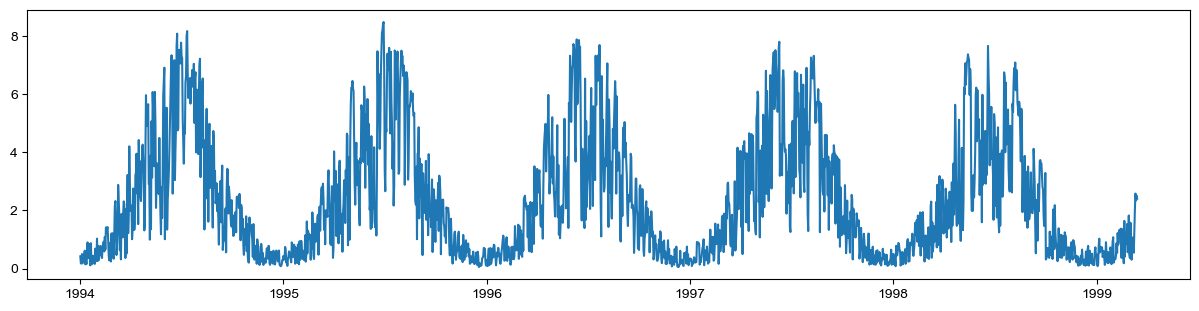

In [22]:
fig, ax = plt.subplots(figsize=(15, 3.5))
plt.plot(pET_k[0:1900])